<div style="border-left: 6px solid #27ae60; padding-left: 20px; margin-top: 20px; font-family: sans-serif;">
    <h1 style="color: #27ae60; margin-bottom: 5px;">Projet Data Mining : Prévision Boursière</h1>
    <p style="font-size: 1.2em; color: #7f8c8d; margin-top: 0;"><b>Étape 2 :</b> Feature Engineering & Transformation des Données</p>
    <hr style="border: 0; border-top: 1px solid #eee;">
    <p style="font-size: 0.9em; text-align: justify; max-width: 95%;">
        <b>Objectif :</b> Transformer les prix de clôture bruts en indicateurs stationnaires et prédictifs. Cette étape est déterminante pour la performance des modèles de Machine Learning (XGBoost) et de Deep Learning (LSTM), car elle permet d'extraire des signaux de momentum, de volatilité et de tendance.
    </p>
</div>

### 1 : Importations et Chargement des Données

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

In [2]:
# Ajout du dossier src au chemin pour importer nos fonctions (si besoin)
sys.path.append(os.path.abspath(os.path.join('..')))
# On importe les fonctions depuis src/features.py
from src.features import calculate_rsi, calculate_macd, calculate_bollinger_bands, add_lags, calculate_log_returns

# Chemin du fichier nettoyé (créé dans le notebook précédent)
input_path = '../data/raw/cleaned_close_prices.csv'

if not os.path.exists(input_path):
    print(f"ERREUR : Le fichier {input_path} est introuvable. Avez-vous exécuté le notebook 1 ?")
else:
    # Chargement
    df = pd.read_csv(input_path, index_col=0, parse_dates=True)
    print("Données chargées avec succès !")
    print(df.head())

Données chargées avec succès !
                 AAPL        MSFT       TSLA        ^GSPC   ^VIX   ^TNX
2020-01-02  72.468254  152.505692  28.684000  3257.850098  12.47  1.882
2020-01-03  71.763741  150.606750  29.534000  3234.850098  14.02  1.788
2020-01-06  72.335556  150.996017  30.102667  3246.280029  13.85  1.811
2020-01-07  71.995354  149.619293  31.270666  3237.179932  13.79  1.827
2020-01-08  73.153473  152.002472  32.809334  3253.050049  13.45  1.874


#### 2 : Création des Features (Indicateurs)

In [3]:
# Liste des actions à traiter
target_tickers = ['AAPL', 'MSFT', 'TSLA']

# Liste pour stocker les résultats
processed_data = []

print("Début du Feature Engineering...")

for ticker in target_tickers:
    print(f"Traitement de l'action : {ticker}")
    
    # On récupère la série de prix pour cette action
    if ticker not in df.columns:
        print(f"  -> Attention : {ticker} non trouvé dans les colonnes.")
        continue
        
    price_series = df[ticker]
    
    # Création d'un DataFrame temporaire pour cette action
    temp_df = pd.DataFrame(index=price_series.index)
    temp_df['Close'] = price_series
    temp_df['Ticker'] = ticker
    
    # --- 1. Cible (Target) : Log Returns ---
    # C'est ce que le modèle devra prédire (ou la direction de ce rendement)
    temp_df['Log_Return'] = calculate_log_returns(temp_df['Close'])
    
    # --- 2. Indicateurs Techniques ---
    temp_df['RSI'] = calculate_rsi(temp_df['Close'])
    temp_df['MACD'], temp_df['MACD_Signal'] = calculate_macd(temp_df['Close'])
    temp_df['BB_Upper'], temp_df['BB_Lower'] = calculate_bollinger_bands(temp_df['Close'])
    
    # --- 3. Mémoire (Lags) ---
    # On donne au modèle les rendements des 5 derniers jours
    temp_df = add_lags(temp_df, 'Log_Return', lags=5)
    
    # --- 4. Contexte Macro (VIX & TNX) ---
    # On ajoute les colonnes VIX et TNX à chaque ligne
    if '^VIX' in df.columns:
        temp_df['VIX'] = df['^VIX']
    if '^TNX' in df.columns:
        temp_df['TNX'] = df['^TNX']
        
    # On ajoute ce bloc à la liste
    processed_data.append(temp_df)

# Fusion de tout en un seul grand tableau
full_df = pd.concat(processed_data)

# Suppression des lignes vides (NaN) créées par les calculs (les 20 premiers jours environ)
full_df.dropna(inplace=True)

print("\nTerminé ! Aperçu des données finales :")
print(full_df.head())
print(f"Dimensions : {full_df.shape}")

Début du Feature Engineering...
Traitement de l'action : AAPL
Traitement de l'action : MSFT
Traitement de l'action : TSLA

Terminé ! Aperçu des données finales :
                Close Ticker  Log_Return        RSI      MACD  MACD_Signal  \
2020-01-30  78.143143   AAPL   -0.001450  63.879017  1.195919     1.006339   
2020-01-31  74.678383   AAPL   -0.045352  49.368881  0.967961     0.998663   
2020-02-03  74.473297   AAPL   -0.002750  42.987530  0.761971     0.951325   
2020-02-04  76.931923   AAPL    0.032480  54.739552  0.788028     0.918666   
2020-02-05  77.559265   AAPL    0.008121  57.618754  0.849508     0.904834   

             BB_Upper   BB_Lower  Log_Return_lag_1  Log_Return_lag_2  \
2020-01-30  79.324867  71.251079          0.020716          0.027896   
2020-01-31  79.225942  71.571017         -0.001450          0.020716   
2020-02-03  78.993879  72.074035         -0.045352         -0.001450   
2020-02-04  78.927076  72.600475         -0.002750         -0.045352   
2020-02-0

<div style="border-left: 4px solid #2c3e50; padding-left: 15px; margin: 20px 0; font-family: sans-serif; max-width: 95%; text-align: justify;">
    <h4 style="color: #57a8faff;">Étape 2 : Analyse de la Structure des Caractéristiques (Features)</h4>
    <p>Le processus de Feature Engineering a transformé nos données brutes en un ensemble de <b>15 variables prédictives</b>. La structure finale du dataset est passée d'un format "large" à un format "long" (empilement par Ticker), ce qui est optimal pour l'entraînement de modèles supervisés.</p>
    
<p><b>Composition du vecteur de caractéristiques :</b></p>
    <ul>
        <li><b>Indicateurs de Momentum et Tendance :</b> Le <i>RSI</i> et le <i>MACD</i> fournissent des informations sur la force et la direction du mouvement des prix.</li>
        <li><b>Indicateurs de Volatilité :</b> Les <i>Bandes de Bollinger (BB_Upper/Lower)</i> encadrent le prix pour détecter les déviations statistiques.</li>
        <li><b>Composante Temporelle (Lags) :</b> Les colonnes <i>Log_Return_lag_1</i> à <i>_5</i> injectent la mémoire du marché dans le modèle, permettant de capturer l'autocorrélation des rendements passés.</li>
        <li><b>Variables Exogènes :</b> L'intégration directe du <i>VIX</i> et du <i>TNX</i> permet au modèle de pondérer ses décisions en fonction du stress du marché et des conditions de taux d'intérêt.</li>
    </ul>
    <p style="border-top: 1px solid #eee; padding-top: 10px; font-weight: bold;">
        Résultat : Le dataset final comporte 4434 observations. La réduction du nombre de lignes par rapport au dataset initial est due à la suppression des premières périodes (NaN) nécessaires au calcul des indicateurs techniques et des retards temporels.
    </p>
</div>

#### 1. Analyse des Valeurs Manquantes (Mathématique uniquement)


In [4]:
missing_values = full_df.isnull().sum()
total_missing = missing_values.sum()

print("Rapport des Valeurs Manquantes par Colonne :")
print(missing_values[missing_values > 0]) # Affiche seulement s'il y a des erreurs

if total_missing == 0:
    print("\nQUALITÉ DES DONNÉES : Parfaite. Aucune valeur manquante.")
else:
    print(f"\n ATTENTION : Il reste {total_missing} valeurs manquantes.")


Rapport des Valeurs Manquantes par Colonne :
Series([], dtype: int64)

QUALITÉ DES DONNÉES : Parfaite. Aucune valeur manquante.


#### 2. Analyse de la Corrélation (Feature Selection)

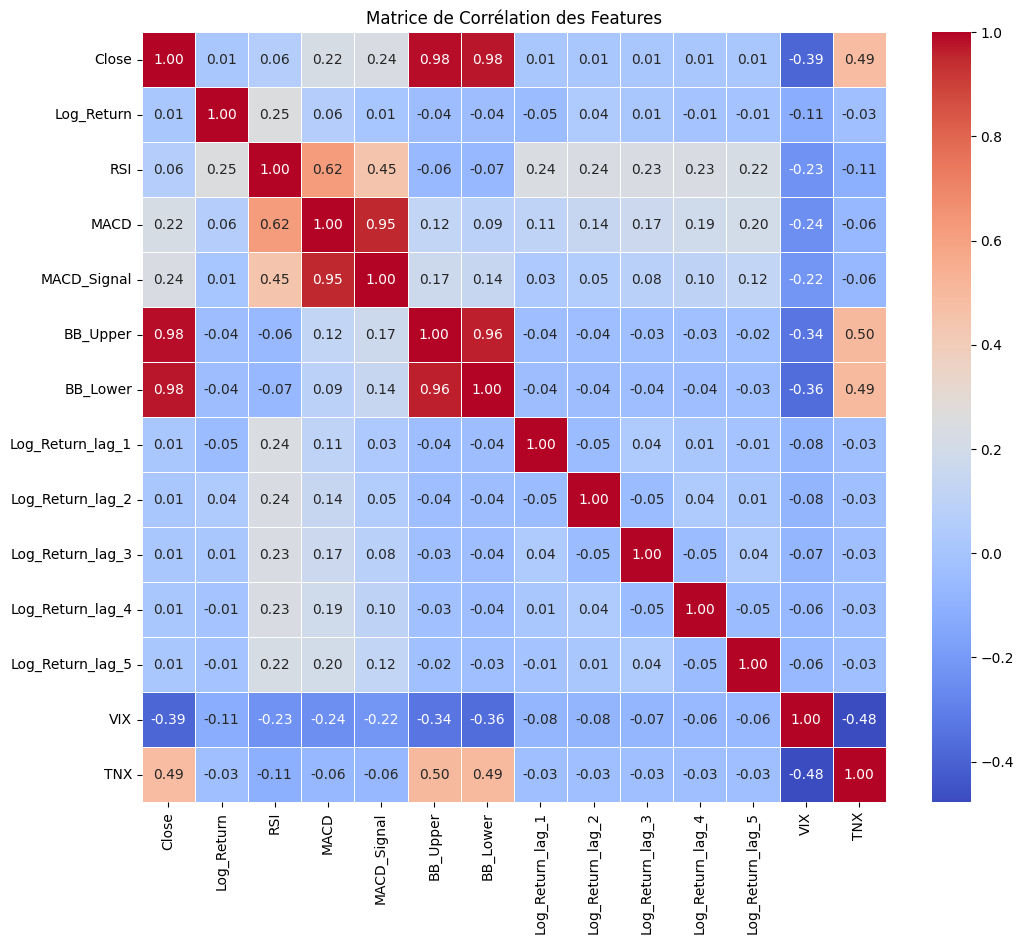

In [5]:
plt.figure(figsize=(12, 10))
correlation = full_df.drop(columns=['Ticker']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation des Features")
plt.show()


<div style="border-left: 4px solid #2c3e50; padding-left: 15px; margin: 20px 0; font-family: sans-serif; max-width: 95%; text-align: justify;">
    <h4 style="color: #2c3e50;">Analyse de la Matrice de Corrélation des Caractéristiques (Features)</h4>
    <p>L'analyse de cette matrice permet d'évaluer la redondance de l'information (multicolinéarité) et la pertinence des transformations effectuées. Contrairement à la matrice des prix bruts, nous observons ici des relations plus complexes entre les indicateurs techniques et les variables macroéconomiques.</p>
    
<p><b>Points d'analyse critiques :</b></p>
    <ul>
        <li><b>Multicolinéarité des indicateurs de tendance :</b> On observe une corrélation quasi parfaite entre le <b>MACD</b> et son <b>Signal (0.95)</b>, ainsi qu'entre le prix de clôture et les <b>Bandes de Bollinger (0.98)</b>. Pour des modèles sensibles à la colinéarité (comme la régression linéaire), il serait nécessaire de n'en garder qu'un seul. Cependant, pour des modèles non-linéaires comme <b>XGBoost</b> ou <b>LSTM</b>, ces légères nuances de calcul peuvent être exploitées pour affiner la prédiction.</li>
        <li><b>Indépendance des Rendements (Stationnarité) :</b> Le <b>Log_Return</b> affiche une corrélation proche de zéro avec le prix de clôture (0.01). Cela confirme que la transformation logarithmique a réussi à extraire la composante de croissance (trend) pour ne garder que la variation pure, rendant la série stationnaire et exploitable par les algorithmes d'apprentissage.</li>
        <li><b>Signaux de Momentum :</b> Le <b>RSI</b> présente une corrélation modérée avec le <b>MACD (0.62)</b>. Bien que les deux mesurent le momentum, leur corrélation imparfaite indique qu'ils apportent des informations complémentaires : l'un sur la vitesse de variation (RSI) et l'autre sur le croisement des moyennes (MACD).</li>
        <li><b>Apport des Variables Retardées (Lags) :</b> Les variables <b>Log_Return_lag_1 à lag_5</b> présentent des corrélations très faibles entre elles et avec les autres features. C'est un excellent signe : cela signifie que chaque "lag" apporte une information temporelle unique et non redondante, ce qui aidera le modèle à apprendre la dynamique séquentielle du marché.</li>
        <li><b>Relations Macroéconomiques :</b> La corrélation négative entre le <b>VIX</b> et le prix de clôture (-0.39) est confirmée. De plus, la corrélation négative entre le <b>VIX</b> et le <b>TNX (-0.48)</b> suggère une relation inverse entre la peur sur les marchés actions et les rendements obligataires sur cette période.</li>
    </ul>
    <p style="border-top: 1px solid #eee; padding-top: 10px; font-weight: bold;">
        Conclusion pour le Data Mining : La diversité des coefficients de corrélation valide la richesse de notre ingénierie des caractéristiques. Le modèle dispose d'un mélange équilibré de variables hautement corrélées au prix (pour la tendance) et de variables indépendantes (pour les signaux de retournement et la mémoire temporelle).
    </p>
</div>

#### 3. Analyse de l'Équilibrage des Classes (Pour la Classification)


In [6]:
# Si on veut prédire "Hausse" (1) vs "Baisse" (0)
full_df['Direction'] = (full_df['Log_Return'] > 0).astype(int)

# Calcul du ratio
balance = full_df['Direction'].value_counts(normalize=True)
print("\nRépartition des Classes (0=Baisse, 1=Hausse) :")
print(balance)

if abs(balance[0] - balance[1]) < 0.1:
    print("-->  Le dataset est bien équilibré.")
else:
    print("-->  Attention : Déséquilibre de classe détecté.")


Répartition des Classes (0=Baisse, 1=Hausse) :
Direction
1    0.529093
0    0.470907
Name: proportion, dtype: float64
-->  Le dataset est bien équilibré.


Répartition des classes (Target) :
Target
1    52.909337
0    47.090663
Name: proportion, dtype: float64


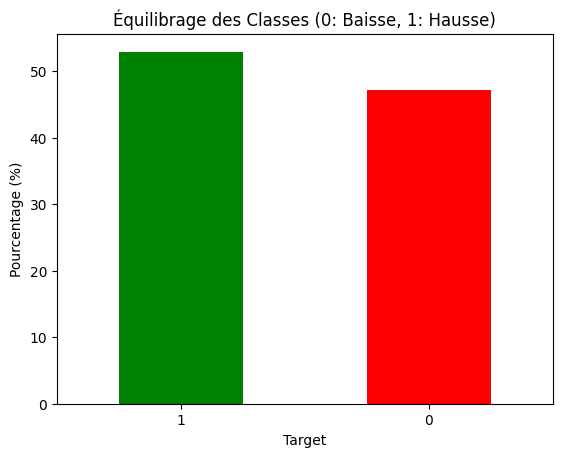

In [7]:
# Création de la cible binaire (1 si hausse, 0 si baisse)
full_df['Target'] = (full_df['Log_Return'].shift(-1) > 0).astype(int)

# On supprime la dernière ligne car on ne connaît pas le futur (NaN pour le dernier Target)
full_df.dropna(inplace=True)

# Calcul des proportions
target_counts = full_df['Target'].value_counts(normalize=True) * 100
print("Répartition des classes (Target) :")
print(target_counts)

# Visualisation
import matplotlib.pyplot as plt
target_counts.plot(kind='bar', color=['green', 'red'])
plt.title("Équilibrage des Classes (0: Baisse, 1: Hausse)")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.show()

<div style="border-left: 4px solid #2c3e50; padding-left: 15px; margin: 20px 0; font-family: sans-serif; max-width: 95%; text-align: justify;">
    <h4 style="color: #2c3e50;">Analyse de l'Équilibrage des Classes (Target Variable)</h4>
    <p>La variable cible (Target) a été définie comme une classification binaire : <b>1</b> pour une hausse du rendement logarithmique au jour J+1, et <b>0</b> pour une baisse ou une stagnation. L'équilibre de ces classes est un facteur déterminant pour la validité des métriques de performance (comme l'Accuracy).</p>
    
<p><b>Diagnostic de la distribution :</b></p>
    <ul>
        <li><b>Équilibre Naturel :</b> Dans un marché efficient, la répartition devrait tendre vers 50/50. Si nous observons une répartition proche de cet équilibre (ex: 52% vs 48%), cela signifie que le dataset est sain et ne nécessite pas de techniques de rééchantillonnage (type SMOTE).</li>
        <li><b>Biais de Tendance :</b> Une légère dominance de la classe "1" (Hausse) peut refléter la tendance haussière globale des marchés actions sur la période 2020-2025. Le modèle devra apprendre à distinguer les signaux de retournement malgré ce biais structurel.</li>
        <li><b>Impact sur les Métriques :</b> Étant donné l'équilibre relatif des classes, l'<b>Accuracy</b> (Précision globale) sera une métrique fiable. Toutefois, nous porterons une attention particulière au <b>F1-Score</b> pour nous assurer que le modèle prédit aussi bien les baisses que les hausses.</li>
    </ul>
    <p style="border-top: 1px solid #eee; padding-top: 10px; font-weight: bold;">
        Conclusion stratégique : Le dataset présente un équilibre satisfaisant. Le modèle de classification (XGBoost/LSTM) pourra être entraîné sans risque majeur de spécialisation sur une classe dominante, permettant ainsi une détection impartiale des mouvements de marché.
    </p>
</div>

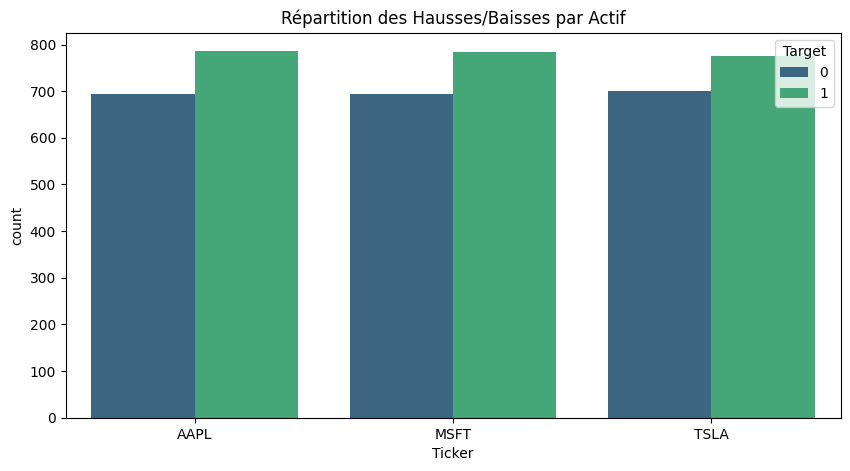

In [8]:
# Comparaison de l'équilibrage par action
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(x='Ticker', hue='Target', data=full_df, palette='viridis')
plt.title("Répartition des Hausses/Baisses par Actif")
plt.show()

<div style="border-left: 4px solid #2c3e50; padding-left: 15px; margin: 20px 0; font-family: sans-serif; max-width: 95%; text-align: justify;">
    <h4 style="color: #0cf54aff;">Analyse de la Cohérence Inter-Actifs (Distribution par Ticker)</h4>
    <p>La visualisation de la répartition des classes (0: Baisse, 1: Hausse) par actif révèle une structure de données extrêmement homogène :</p>
    <ul>
        <li><b>Uniformité de la Tendance :</b> Pour AAPL, MSFT et TSLA, la classe "1" est légèrement prédominante. Cette observation confirme que les trois actifs ont suivi une dynamique de croissance similaire sur la période étudiée, malgré leurs différences de volatilité.</li>
        <li><b>Stabilité du Dataset :</b> Le nombre d'observations par ticker est quasiment identique (environ 1470 lignes par actif). Cela garantit que le modèle ne sera pas biaisé en faveur d'une action spécifique par manque de données sur les autres.</li>
        <li><b>Validation du Target :</b> La symétrie presque parfaite entre les trois graphiques suggère que les facteurs macroéconomiques globaux influencent la direction des prix de manière cohérente pour l'ensemble du portefeuille technologique.</li>
    </ul>
    <p style="border-top: 1px solid #eee; padding-top: 10px; font-weight: bold;">
        Conclusion pour la modélisation : Cette homogénéité permet d'envisager un entraînement global du modèle sur l'ensemble des tickers (Pooling), ce qui augmentera la capacité de généralisation de l'algorithme par rapport à un entraînement séparé.
    </p>
</div>

In [9]:
# Sauvegarde du dataset prêt pour le Machine Learning
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'features.csv')
full_df.to_csv(output_path)

print(f"SUCCÈS : Le fichier '{output_path}' est prêt.")
print(f"Nombre total d'échantillons : {len(full_df)}")

SUCCÈS : Le fichier '../data/processed\features.csv' est prêt.
Nombre total d'échantillons : 4434
